In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from time import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
import random
import sqlite3

#metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

import pickle
#functions for reading and saving file

def read(obj,fn):
    pickle.dump(obj,open(fn+'.p','wb'))
    
def save(fn):
    t=pickle.load(fn+".p","rb")
    return t


In [3]:
#creating dataframe from csv file
df=pd.read_csv("final.csv")
df.head()

,Unnamed: 0,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read aloud- nice rhythm well ...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


In [4]:
#taking random 25k sample
df=df.sample(100000)
df.shape

(100000, 12)

In [5]:
df1=df.sample(25000)
df1.shape

(25000, 12)

In [6]:
#sorting data by time
df.sort_values("Time",inplace=True)
df1.sort_values("Time",inplace=True)

# Unigram

In [8]:
#splitting the data into train and test
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing

X_train,X_test,Y_train,Y_test=train_test_split(df['CleanedText'].values,df['Score'].values,test_size=0.3,shuffle=False)

#text to unigram
unigram=CountVectorizer()

X_train=unigram.fit_transform(X_train)
X_test=unigram.transform(X_test)

#normalizing

X_train=preprocessing.normalize(X_train)
X_test=preprocessing.normalize(X_test)

print("shape of train",X_train.shape)
print("shape of test",X_test.shape)

shape of train (70000, 45130)
shape of test (30000, 45130)


In [11]:
#splitting the data into train and test
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing

X_train1,X_test1,Y_train1,Y_test1=train_test_split(df1['CleanedText'].values,df1['Score'].values,test_size=0.3,shuffle=False)

#text to unigram
unigram=CountVectorizer(min_df=10,max_features=500)

X_train1=unigram.fit_transform(X_train1)
X_test1=unigram.transform(X_test1)

#normalizing

X_train1=preprocessing.normalize(X_train1)
X_test1=preprocessing.normalize(X_test1)

print("shape of train",X_train1.shape)
print("shape of test",X_test1.shape)

shape of train (17500, 500)
shape of test (7500, 500)


In [12]:
#10 fold cross validation
from sklearn.model_selection import TimeSeriesSplit

tscv=TimeSeriesSplit(n_splits=10)
for train,cv in tscv.split(X_train):
    print(X_train[train].shape,X_train[cv].shape)

(6370, 45130) (6363, 45130)
(12733, 45130) (6363, 45130)
(19096, 45130) (6363, 45130)
(25459, 45130) (6363, 45130)
(31822, 45130) (6363, 45130)
(38185, 45130) (6363, 45130)
(44548, 45130) (6363, 45130)
(50911, 45130) (6363, 45130)
(57274, 45130) (6363, 45130)
(63637, 45130) (6363, 45130)


## Linear SVM With Calibrated CV

In [15]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier

clf=SGDClassifier(loss='hinge')
param_grid={'C':[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000],
           'penalty':['l1','l2']}
ccv=CalibratedClassifierCV(clf,param_grid,cv=tscv,scoring='roc_auc')
ccv.fit(X_train,Y_train)

TypeError: __init__() got an unexpected keyword argument 'scoring'

accuracy on test 87.47f%
recall on test 95.67f%
precision on test 89.66f%
f1 on test 92.57f%
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



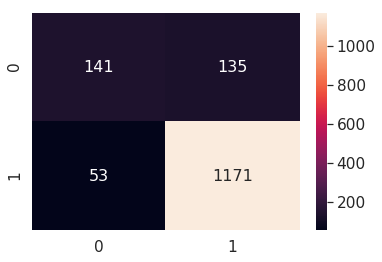

In [10]:
#testing on test data
clf=SVC(gamma=0.05,C=50)
clf.fit(X_train,Y_train)
Y_pred=clf.predict(X_test)

print("accuracy on test %0.2ff%%"%(accuracy_score(Y_test,Y_pred)*100))
print("recall on test %0.2ff%%"%(recall_score(Y_test,Y_pred)*100))
print("precision on test %0.2ff%%"%(precision_score(Y_test,Y_pred)*100))
print("f1 on test %0.2ff%%"%(f1_score(Y_test,Y_pred)*100))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm=pd.DataFrame(confusion_matrix(Y_test,Y_pred),range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm,annot=True,annot_kws={'size':16},fmt='g')
plt.show()


# RandomizedSearchCV

In [11]:
from sklearn.model_selection import RandomizedSearchCV

clf=SVC()
rsv=RandomizedSearchCV(clf,param_grid,cv=tscv,verbose=1)
rsv.fit(X_train,Y_train)

print("best hyperparameter ",rsv.best_params_)
print("best score ",gsv.best_score_*100)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  3.1min finished


best hyperparameter  {'gamma': 0.01, 'C': 500}
best score  87.67295597484276


accuracy on test 85.87f%
recall on test 93.55f%
precision on test 89.59f%
f1 on test 91.53f%
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



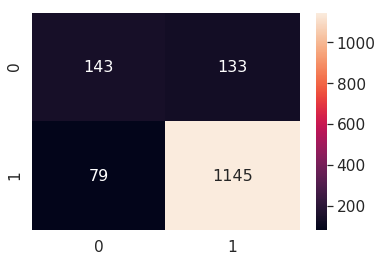

In [12]:
clf=SVC(gamma=0.01,C=500)
clf.fit(X_train,Y_train)
Y_pred=clf.predict(X_test)

print("accuracy on test %0.2ff%%"%(accuracy_score(Y_test,Y_pred)*100))
print("recall on test %0.2ff%%"%(recall_score(Y_test,Y_pred)*100))
print("precision on test %0.2ff%%"%(precision_score(Y_test,Y_pred)*100))
print("f1 on test %0.2ff%%"%(f1_score(Y_test,Y_pred)*100))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm=pd.DataFrame(confusion_matrix(Y_test,Y_pred),range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm,annot=True,annot_kws={'size':16},fmt='g')
plt.show()

# Bigram

In [14]:
X_train,X_test,Y_train,Y_test=train_test_split(df['CleanedText'].values,df['Score'].values,test_size=0.3,shuffle=False)

#text to bigram
bigram=CountVectorizer(ngram_range=(1,2))

X_train=bigram.fit_transform(X_train)
X_test=bigram.transform(X_test)

#normalize
X_train=preprocessing.normalize(X_train)
X_test=preprocessing.normalize(X_test)
print("shape of train ",X_train.shape)
print("shape of test ",X_test.shape)

shape of train  (3500, 102098)
shape of test  (1500, 102098)


# SVC

## GridsearchCV

In [16]:
clf=SVC()
gsv=GridSearchCV(clf,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,Y_train)

print("best hyperparameter : ",gsv.best_params_)
print("best score : ",gsv.best_score_*100)

Fitting 10 folds for each of 225 candidates, totalling 2250 fits


[Parallel(n_jobs=1)]: Done 2250 out of 2250 | elapsed: 109.2min finished


best hyperparameter :  {'C': 1000, 'gamma': 0.01}
best score :  87.0754716981132


accuracy on test 88.87f%
recall on test 97.79f%
precision on test 89.53f%
f1 on test 93.48f%
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



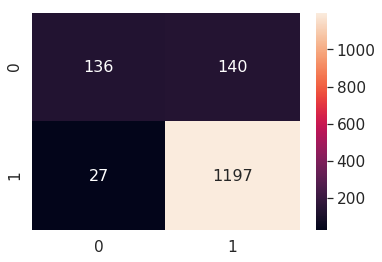

In [17]:
clf=SVC(gamma=0.01,C=1000)
clf.fit(X_train,Y_train)
Y_pred=clf.predict(X_test)

print("accuracy on test %0.2ff%%"%(accuracy_score(Y_test,Y_pred)*100))
print("recall on test %0.2ff%%"%(recall_score(Y_test,Y_pred)*100))
print("precision on test %0.2ff%%"%(precision_score(Y_test,Y_pred)*100))
print("f1 on test %0.2ff%%"%(f1_score(Y_test,Y_pred)*100))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm=pd.DataFrame(confusion_matrix(Y_test,Y_pred),range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm,annot=True,annot_kws={'size':16},fmt='g')
plt.show()

## RandomizedSearchCV

In [19]:
clf=SVC()
rsv=RandomizedSearchCV(clf,param_grid,cv=tscv,verbose=1)
rsv.fit(X_train,Y_train)

print("best hyperparameter ",rsv.best_params_)
print("best score ",gsv.best_score_*100)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  4.2min finished


best hyperparameter  {'gamma': 0.001, 'C': 1000}
best score  87.0754716981132


accuracy on test 88.67f%
recall on test 98.28f%
precision on test 88.98f%
f1 on test 93.40f%
confusion_matrix on test 
 [ [TN  FP]
 [FN TP] ]



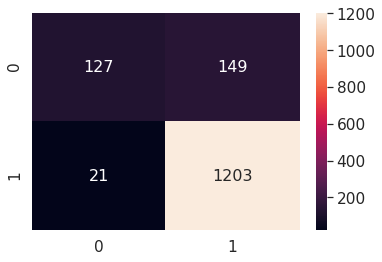

In [22]:
clf=SVC(C=1000,gamma=0.001)
clf.fit(X_train,Y_train)
Y_pred=clf.predict(X_test)

print("accuracy on test %.2ff%%"%(accuracy_score(Y_test,Y_pred)*100))
print("recall on test %.2ff%%"%(recall_score(Y_test,Y_pred)*100))
print("precision on test %.2ff%%"%(precision_score(Y_test,Y_pred)*100))
print("f1 on test %.2ff%%"%(f1_score(Y_test,Y_pred)*100))
print("confusion_matrix on test \n [ [TN  FP]\n [FN TP] ]\n")

df_cm=pd.DataFrame(confusion_matrix(Y_test,Y_pred),range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm,annot=True,annot_kws={'size':16},fmt='g')

# Tfidf

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#splitting the data into train and test

X_train,X_test,Y_train,Y_test=train_test_split(df['CleanedText'].values,df['Score'].values,test_size=0.3,shuffle=False)

#text to tfidf vector
tfidf=TfidfVectorizer()
X_train=tfidf.fit_transform(X_train)
X_test=tfidf.transform(X_test)

#normalize
X_train=preprocessing.normalize(X_train)
X_test=preprocessing.normalize(X_test)

print("shape of train ",X_train.shape)
print("shape of test ",X_test.shape)

shape of train  (3500, 8257)
shape of test  (1500, 8257)


In [9]:
#10 fold cross validation
from sklearn.model_selection import TimeSeriesSplit
tscv=TimeSeriesSplit(n_splits=10)

for train,cv in tscv.split(X_train):
    print(X_train[train].shape,X_train[cv].shape)

(320, 8257) (318, 8257)
(638, 8257) (318, 8257)
(956, 8257) (318, 8257)
(1274, 8257) (318, 8257)
(1592, 8257) (318, 8257)
(1910, 8257) (318, 8257)
(2228, 8257) (318, 8257)
(2546, 8257) (318, 8257)
(2864, 8257) (318, 8257)
(3182, 8257) (318, 8257)


# SVC

## GridSearchCV

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

clf=SVC()
param_grid={'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
           'gamma':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]}
gsv=GridSearchCV(clf,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,Y_train)
print("best hyperparameter ",gsv.best_params_)
print("best score ",gsv.best_score_*100)

Fitting 10 folds for each of 225 candidates, totalling 2250 fits


[Parallel(n_jobs=1)]: Done 2250 out of 2250 | elapsed: 64.8min finished


best hyperparameter  {'C': 10, 'gamma': 0.1}
best score  87.76729559748428


accuracy on test 88.80f%
precision on test 90.34f%
recall on test 96.87f%
f1 on test 93.49f%
confusion matrix on test 
 [ [TN  FP]
 [FN TP] ]



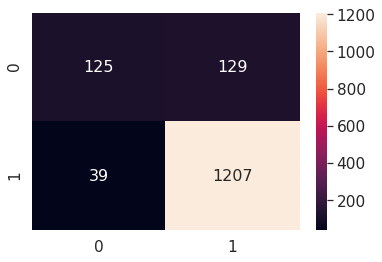

In [12]:
#testing on test data
clf=SVC(C=10,gamma=0.1)
clf.fit(X_train,Y_train)
Y_pred=clf.predict(X_test)

print("accuracy on test %0.2ff%%"%(accuracy_score(Y_test,Y_pred)*100))
print("precision on test %0.2ff%%"%(precision_score(Y_test,Y_pred)*100))
print("recall on test %0.2ff%%"%(recall_score(Y_test,Y_pred)*100))
print("f1 on test %0.2ff%%"%(f1_score(Y_test,Y_pred)*100))
print("confusion matrix on test \n [ [TN  FP]\n [FN TP] ]\n")

df_cm=pd.DataFrame(confusion_matrix(Y_test,Y_pred),range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm,annot=True,annot_kws={'size':16},fmt='g')
plt.show()

## RandomizedSearchCV

In [13]:
from sklearn.model_selection import RandomizedSearchCV
clf=SVC()
rsv=RandomizedSearchCV(clf,param_grid,cv=tscv,verbose=1)
rsv.fit(X_train,Y_train)

print("best hyperparameter ",rsv.best_params_)
print("best score ",rsv.best_score_*100)


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  3.5min finished


best hyperparameter  {'gamma': 1, 'C': 1}
best score  85.44025157232704


accuracy on test 84.93f%
precision on test 84.79f%
recall on test 99.76f%
f1 on test 91.67f%
confusion matrix on test 
 [ [TN  FP]
 [FN TP] ]



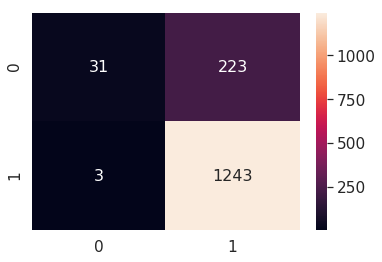

In [14]:
#testing on test data
clf=SVC(gamma=1,C=1)
clf.fit(X_train,Y_train)
Y_pred=clf.predict(X_test)

print("accuracy on test %.2ff%%"%(accuracy_score(Y_test,Y_pred)*100))
print("precision on test %.2ff%%"%(precision_score(Y_test,Y_pred)*100))
print("recall on test %.2ff%%"%(recall_score(Y_test,Y_pred)*100))
print("f1 on test %.2ff%%"%(f1_score(Y_test,Y_pred)*100))
print("confusion matrix on test \n [ [TN  FP]\n [FN TP] ]\n")

df_cm=pd.DataFrame(confusion_matrix(Y_test,Y_pred),range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm,annot=True,annot_kws={'size':16},fmt='g')
plt.show()

# Word2Vec

In [15]:
i=0
list_of_sent=[]
for sent in df['CleanedText'].values:
    list_of_sent.append(sent.split())
    
print(df['CleanedText'].values[0])
print("******************************************************")
print(list_of_sent[0])

origin bought sadi golden retreiv month show interest cute small squeak toy ginger take mouth like littl puppi insert collect awwwww howev awhil show sporad interest appear would much rather show chop chew bite wrestl larger stuf anim gorilla current favorit howev pound old boy love first bought sever year ago hedgehog soft cudd perfect size probabl cost less stuf anim design specif children either dog child hedgehog sire find love bite home
******************************************************
['origin', 'bought', 'sadi', 'golden', 'retreiv', 'month', 'show', 'interest', 'cute', 'small', 'squeak', 'toy', 'ginger', 'take', 'mouth', 'like', 'littl', 'puppi', 'insert', 'collect', 'awwwww', 'howev', 'awhil', 'show', 'sporad', 'interest', 'appear', 'would', 'much', 'rather', 'show', 'chop', 'chew', 'bite', 'wrestl', 'larger', 'stuf', 'anim', 'gorilla', 'current', 'favorit', 'howev', 'pound', 'old', 'boy', 'love', 'first', 'bought', 'sever', 'year', 'ago', 'hedgehog', 'soft', 'cudd', 'perf

In [20]:
from gensim.models import Word2Vec
w2v_model=Word2Vec(list_of_sent,min_count=5,size=300,workers=4)

In [21]:
w2v_words=list(w2v_model.wv.vocab)
print("sample_words ",w2v_words[0:50])

sample_words  ['origin', 'bought', 'golden', 'month', 'show', 'interest', 'cute', 'small', 'toy', 'ginger', 'take', 'mouth', 'like', 'littl', 'puppi', 'insert', 'collect', 'howev', 'awhil', 'appear', 'would', 'much', 'rather', 'chop', 'chew', 'bite', 'larger', 'stuf', 'anim', 'current', 'favorit', 'pound', 'old', 'boy', 'love', 'first', 'sever', 'year', 'ago', 'soft', 'perfect', 'size', 'probabl', 'cost', 'less', 'design', 'specif', 'children', 'either', 'dog']


# Average Word2Vec

In [22]:
from tqdm import tqdm
sent_vectors=[]
for sent in tqdm(list_of_sent):
    sent_vec=np.zeros(300)
    cnt_words=0
    for word in sent:
        if word in w2v_words:
            vec=w2v_model.wv[word]
            sent_vec+=vec
            cnt_words+=1
    if cnt_words!=0:
        sent_vec/=cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 5000/5000 [00:05<00:00, 932.91it/s] 

5000
300


In [34]:
#normalizing avg_word2Vec
avg_vec_norm=preprocessing.normalize(sent_vectors)

#breaking into train and test 
X_train,X_test,Y_train,Y_test=train_test_split(avg_vec_norm,df['Score'].values,test_size=0.3,shuffle=False)
print("shape of train ",X_train.shape)
print("shape of test ",X_test.shape)

shape of train  (3500, 300)
shape of test  (1500, 300)


# SVC

## GridSearchCV

In [26]:
clf=SVC()
gsv=GridSearchCV(clf,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,Y_train)

print("best hyperparameter ",gsv.best_params_)
print("best score ",gsv.best_score_)

Fitting 10 folds for each of 225 candidates, totalling 2250 fits


[Parallel(n_jobs=1)]: Done 2250 out of 2250 | elapsed: 51.6min finished


best hyperparameter  {'C': 1000, 'gamma': 10}
best score  0.8575471698113207


accuracy on test 84.53f%
precision on test 85.41f%
recall on test 98.15f%
f1 on test 91.34f%
confusion matrix on test 
 [ [TN  FP]
 [FN TP] ]



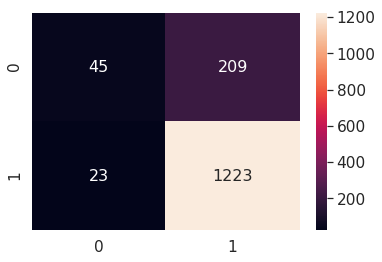

In [28]:
#testing on test data

clf=SVC(C=1000,gamma=10)
clf.fit(X_train,Y_train)
Y_pred=clf.predict(X_test)

print("accuracy on test %0.2ff%%"%(accuracy_score(Y_test,Y_pred)*100))
print("precision on test %0.2ff%%"%(precision_score(Y_test,Y_pred)*100))
print("recall on test %0.2ff%%"%(recall_score(Y_test,Y_pred)*100))
print("f1 on test %0.2ff%%"%(f1_score(Y_test,Y_pred)*100))
print("confusion matrix on test \n [ [TN  FP]\n [FN TP] ]\n")

df_cm=pd.DataFrame(confusion_matrix(Y_test,Y_pred),range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm,annot=True,annot_kws={'size':16},fmt='g')
plt.show()

# RandomizedSearchCV

In [35]:
from sklearn.model_selection import RandomizedSearchCV
clf=SVC()
rsv=RandomizedSearchCV(clf,param_grid,cv=tscv,verbose=1)
rsv.fit(X_train,Y_train)

print("best hyperparameter ",rsv.best_params_)
print("best score ",rsv.best_score_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.4min finished


best hyperparameter  {'gamma': 1, 'C': 0.1}
best score  0.85062893081761


accuacy on test 83.07f%
precision on test 83.07f%
recall on test 100.00f%
f1 on test 90.75f%
confusion matrix on test [[TN FP]
[FN TP]]



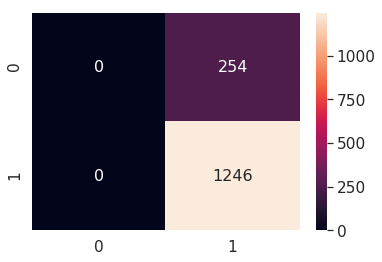

In [37]:
#testing on testdata

clf=SVC(gamma=1,C=0.1)
clf.fit(X_train,Y_train)
Y_pred=clf.predict(X_test)

print("accuacy on test %0.2ff%%"%(accuracy_score(Y_test,Y_pred)*100))
print("precision on test %0.2ff%%"%(precision_score(Y_test,Y_pred)*100))
print("recall on test %0.2ff%%"%(recall_score(Y_test,Y_pred)*100))
print("f1 on test %0.2ff%%"%(f1_score(Y_test,Y_pred)*100))
print("confusion matrix on test [[TN FP]\n[FN TP]]\n")

df_cm=pd.DataFrame(confusion_matrix(Y_test,Y_pred),range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm,annot=True,annot_kws={'size':16},fmt='g')
plt.show()

# Average Tfidf

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(df['CleanedText'].values)

dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [31]:

tfidf_feat = model.get_feature_names()

tfidf_sent_vectors = []; 
row=0;
for sent in tqdm(list_of_sent):  
    sent_vec = np.zeros(300) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
             
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 5000/5000 [00:05<00:00, 847.15it/s]


In [38]:
tfidf_vect_norm=preprocessing.normalize(tfidf_sent_vectors)
#splitiing data into train and test
X_train,X_test,Y_train,Y_test=train_test_split(tfidf_vect_norm,df['Score'].values,test_size=0.3,shuffle=False)

print("shape of train ",X_train.shape)
print("shape of test ",X_test.shape)

shape of train  (3500, 300)
shape of test  (1500, 300)


# GridSearchCV

In [33]:
clf=SVC()
gsv=GridSearchCV(clf,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,Y_train)

print("best hyperparameter ",gsv.best_params_)
print("best score ",gsv.best_score_)

Fitting 10 folds for each of 225 candidates, totalling 2250 fits


[Parallel(n_jobs=1)]: Done 2250 out of 2250 | elapsed: 52.7min finished


best hyperparameter  {'C': 1000, 'gamma': 10}
best score  0.85062893081761


accuacy on test 81.87f%
precision on test 85.34f%
recall on test 94.38f%
f1 on test 89.63f%
confusion matrix on test [[TN FP]
[FN TP]]



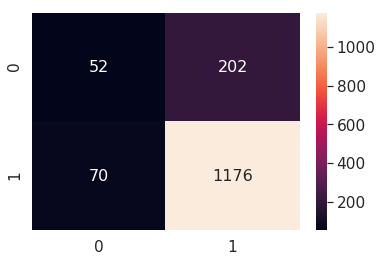

In [39]:
#testing on test data
clf=SVC(C=10,gamma=1000)
clf.fit(X_train,Y_train)
Y_pred=clf.predict(X_test)

print("accuacy on test %0.2ff%%"%(accuracy_score(Y_test,Y_pred)*100))
print("precision on test %0.2ff%%"%(precision_score(Y_test,Y_pred)*100))
print("recall on test %0.2ff%%"%(recall_score(Y_test,Y_pred)*100))
print("f1 on test %0.2ff%%"%(f1_score(Y_test,Y_pred)*100))
print("confusion matrix on test [[TN FP]\n[FN TP]]\n")

df_cm=pd.DataFrame(confusion_matrix(Y_test,Y_pred),range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm,annot=True,annot_kws={'size':16},fmt='g')
plt.show()

# RandomizedSearchCV

In [40]:
from sklearn.model_selection import RandomizedSearchCV
clf=SVC()
rsv=RandomizedSearchCV(clf,param_grid,cv=tscv,verbose=1)
rsv.fit(X_train,Y_train)

print("best hyperparameter ",rsv.best_params_)
print("best score ",rsv.best_score_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.4min finished


best hyperparameter  {'gamma': 0.01, 'C': 500}
best score  0.85062893081761


accuacy on test 83.07f%
precision on test 83.07f%
recall on test 100.00f%
f1 on test 90.75f%
confusion matrix on test [[TN FP]
[FN TP]]



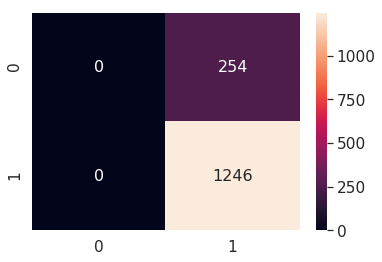

In [41]:
clf=SVC(C=500,gamma=0.01)
clf.fit(X_train,Y_train)
Y_pred=clf.predict(X_test)

print("accuacy on test %0.2ff%%"%(accuracy_score(Y_test,Y_pred)*100))
print("precision on test %0.2ff%%"%(precision_score(Y_test,Y_pred)*100))
print("recall on test %0.2ff%%"%(recall_score(Y_test,Y_pred)*100))
print("f1 on test %0.2ff%%"%(f1_score(Y_test,Y_pred)*100))
print("confusion matrix on test [[TN FP]\n[FN TP]]\n")

df_cm=pd.DataFrame(confusion_matrix(Y_test,Y_pred),range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm,annot=True,annot_kws={'size':16},fmt='g')
plt.show()